# Ocean color

This notebook explores using Satellogic hyperspectral camera for data over the Oceans. [Hyperspectral measurements over water bodies](https://en.wikipedia.org/wiki/Ocean_color) can be used to infer important information such as phytoplankton biomass or concentrations of other living and non-living material that modify the characteristics of the incoming radiation.

In this example we show how to download, mask the water, visualize and cluster hyper data over the coasts of Gambia; but there are very similar ones in, e.g.:
* Qatar: [Telluric data file]()
* Luisiana (USA): [Telluric data file]()
* Southern tip of South Korea: [Telluric data file]()


In [1]:
import os
import numpy as np

hypercube_folder="/home/agus/Descargas/2018-03-22_153735_telluric_catalog_set_257e80_yZ6modw/newsat3_macro_cube_257e8052c6d94b72ada0b788173791fa_0_4_3/rasters/"
files=os.listdir(hypercube_folder) 

hfiles=np.sort([x for x in files if x[-6:]=='nm.tif'])

print("Number of Spectral bands: %i" % (len(hfiles)))
print(hfiles)


Number of Spectral bands: 30
['HyperCube_452_nm.tif' 'HyperCube_462_nm.tif' 'HyperCube_475_nm.tif'
 'HyperCube_488_nm.tif' 'HyperCube_502_nm.tif' 'HyperCube_516_nm.tif'
 'HyperCube_530_nm.tif' 'HyperCube_550_nm.tif' 'HyperCube_570_nm.tif'
 'HyperCube_582_nm.tif' 'HyperCube_595_nm.tif' 'HyperCube_608_nm.tif'
 'HyperCube_616_nm.tif' 'HyperCube_670_nm.tif' 'HyperCube_680_nm.tif'
 'HyperCube_690_nm.tif' 'HyperCube_700_nm.tif' 'HyperCube_710_nm.tif'
 'HyperCube_720_nm.tif' 'HyperCube_730_nm.tif' 'HyperCube_740_nm.tif'
 'HyperCube_750_nm.tif' 'HyperCube_760_nm.tif' 'HyperCube_770_nm.tif'
 'HyperCube_780_nm.tif' 'HyperCube_790_nm.tif' 'HyperCube_800_nm.tif'
 'HyperCube_810_nm.tif' 'HyperCube_820_nm.tif' 'HyperCube_827_nm.tif']


In [3]:
#Read ALL bands, 
# mask them into the ROI and 
# save them into a single multiband cube
# MINIMIZE MEMORY FOOTPRINT

import fiona
import rasterio
from rasterio.mask import mask

#to mask the region we need both images in the same CRS
with fiona.open("Gambia Coast.geojson", "r") as shapefile:
    geoms = [feature["geometry"] for feature in shapefile]

max_cast=40000
min_cast=0

with rasterio.open(hypercube_folder+hfiles[0]) as src:
    out_image, out_transform = mask(src, geoms, crop=True)
cube_dtype=np.uint8 #np.uint16 to have more spectral flux resolution.
cube=np.zeros((np.shape(out_image.data)[1], np.shape(out_image.data)[2],len(hfiles)),dtype=np.uint8)


print("Reading files...",end='')
for i in np.arange(len(hfiles[:])):
    file=hfiles[i]
    print(file,end=", "),
    with rasterio.open(hypercube_folder+file) as src:
        out_image, out_transform = mask(src, geoms, crop=True)
        if out_image.data.dtype == cube.dtype:
            cube[:,:,i]=out_image.data
        else:
            #cast to uint8, to save space
            cube[:,:,i]=((np.clip(out_image.data,min_cast,max_cast)-min_cast)/(max_cast-min_cast))*np.iinfo(cube.dtype).max
print("")

Reading files...HyperCube_452_nm.tif, HyperCube_462_nm.tif, HyperCube_475_nm.tif, HyperCube_488_nm.tif, HyperCube_502_nm.tif, HyperCube_516_nm.tif, HyperCube_530_nm.tif, HyperCube_550_nm.tif, HyperCube_570_nm.tif, HyperCube_582_nm.tif, HyperCube_595_nm.tif, HyperCube_608_nm.tif, HyperCube_616_nm.tif, HyperCube_670_nm.tif, HyperCube_680_nm.tif, HyperCube_690_nm.tif, HyperCube_700_nm.tif, HyperCube_710_nm.tif, HyperCube_720_nm.tif, HyperCube_730_nm.tif, HyperCube_740_nm.tif, HyperCube_750_nm.tif, HyperCube_760_nm.tif, HyperCube_770_nm.tif, HyperCube_780_nm.tif, HyperCube_790_nm.tif, HyperCube_800_nm.tif, HyperCube_810_nm.tif, HyperCube_820_nm.tif, HyperCube_827_nm.tif, 


<IPython.core.display.Javascript object>


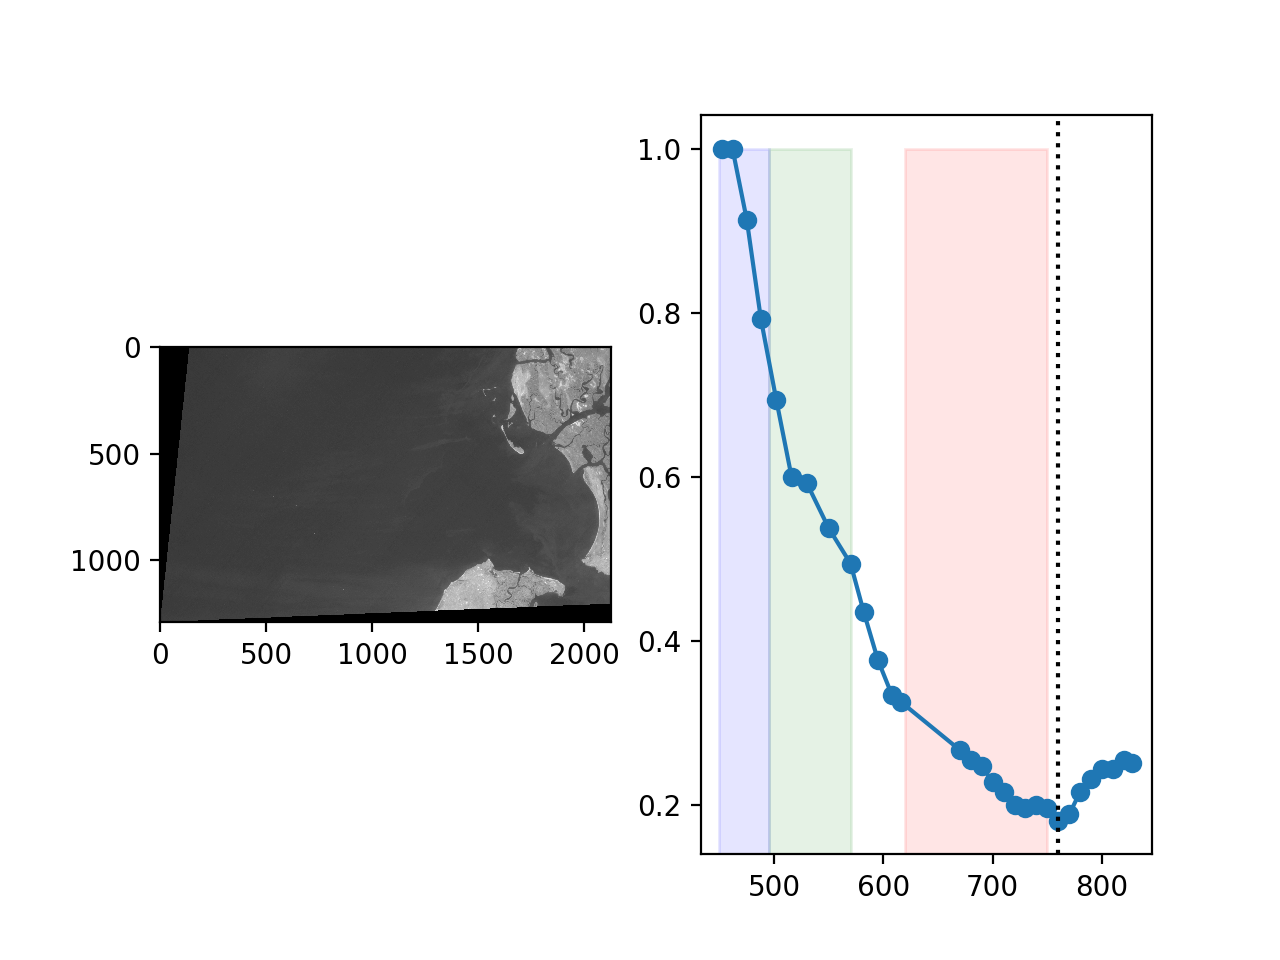

interactive(children=(IntSlider(value=15, description='Channel', max=29), Output()), _dom_classes=('widget-interact',))

In [11]:
#plot the data
%matplotlib notebook
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def macro_plot(c):
    wavelengths = [int(a[10:13]) for a in hfiles]

    i=int(c.shape[2]/2)    
    x=int(c.shape[0]/2)
    y=int(c.shape[1]/2)
    
    fig=plt.figure()
    im=plt.subplot(121)
    s=plt.subplot(122)

    im.cla()
    im.imshow(c[:,:,i])

    red=[620,750]
    green=[495,570]
    blue=[450,495]
    def spectra(i,x,y):
        s.cla()
        s.plot(wavelengths,c[x,y,:]/255,'o-')
        s.axvline(x=wavelengths[i],linestyle=':',color='black')
    
    #add RGB reference
        for p in [
        patches.Rectangle(
            (red[0], 0), red[1]-red[0], 1,
            alpha=.1,Color='red'
        ),
        patches.Rectangle(
            (green[0], 0), green[1]-green[0], 1,
            alpha=.1,Color='green'
        ),
        patches.Rectangle(
            (blue[0], 0), blue[1]-blue[0], 1,
            alpha=.1,Color='blue'
        ),
    ]:
            s.add_patch(p)
        plt.show()

    def onclick(event):
        y=int(event.xdata)
        x=int(event.ydata)
        i=i_slider.value
        spectra(i,x,y)
    im.figure.canvas.mpl_connect('button_press_event', onclick)
    

    def spectrogram(i):
        im.imshow(c[:,:,i], cmap='gray')
        spectra(i,x,y)

    spectrogram(i)
    i_slider = widgets.IntSlider(min=0,
                             max=c.shape[2]-1,
                             step=1,
                             value=c.shape[2]/2,
                             description='Channel')
    interact(spectrogram, i=i_slider)
macro_plot(cube)


In [42]:
from spectral import *
k=2
loops=10
(m, c) = kmeans(cube[:,:,1:], k, loops)


Initializing clusters along diagonal of N-dimensional bounding box.
Iteration 1...  0.Iteration 1...388266 pixels reassigned.
Iteration 2...  0.Iteration 2...180143 pixels reassigned.
Iteration 3...  0.Iteration 3...64848 pixels reassigned.
Iteration 4...  0.Iteration 4...11132 pixels reassigned.
Iteration 5...  0.Iteration 5...1429 pixels reassigned.
Iteration 6...  0.Iteration 6...167 pixels reassigned.
Iteration 7...  0.Iteration 7...23 pixels reassigned.
Iteration 8...  0.Iteration 8...4 pixels reassigned.
Iteration 9...  0.Iteration 9...1 pixels reassigned.
Iteration 10...  0.0Iteration 10...0 pixels reassigned.
kmeans terminated with 2 clusters after 9 iterations.


<IPython.core.display.Javascript object>


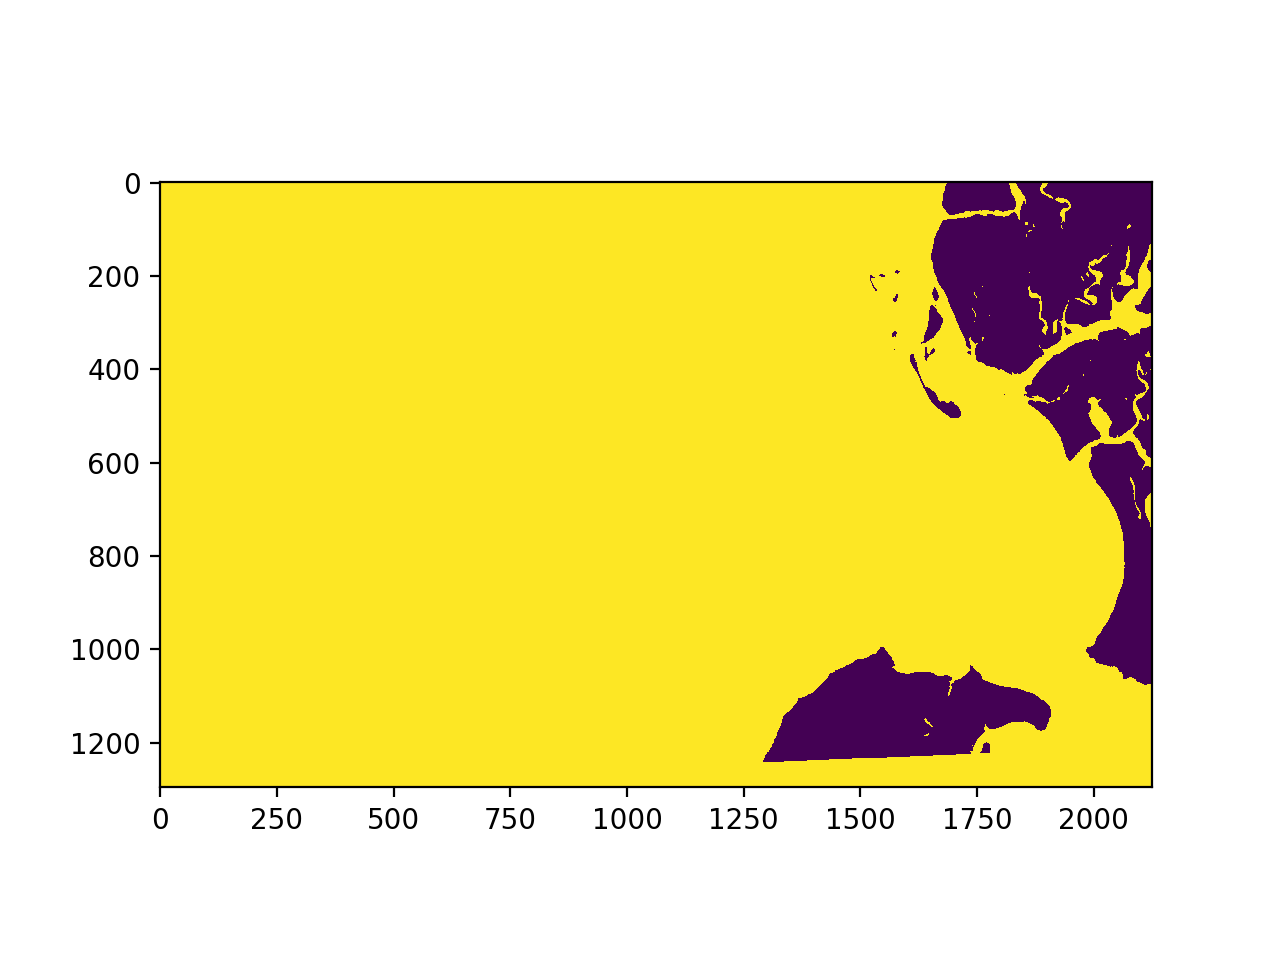

<function matplotlib.pyplot.colorbar>

In [44]:
import matplotlib.cm as cm
km=plt.figure()

base = plt.cm.get_cmap(cm.jet)
cmap=base.from_list('', base(np.linspace(0, 1, k)), k)

mask=1-m.astype('uint8')
plt.imshow(mask)
plt.colorbar

<IPython.core.display.Javascript object>


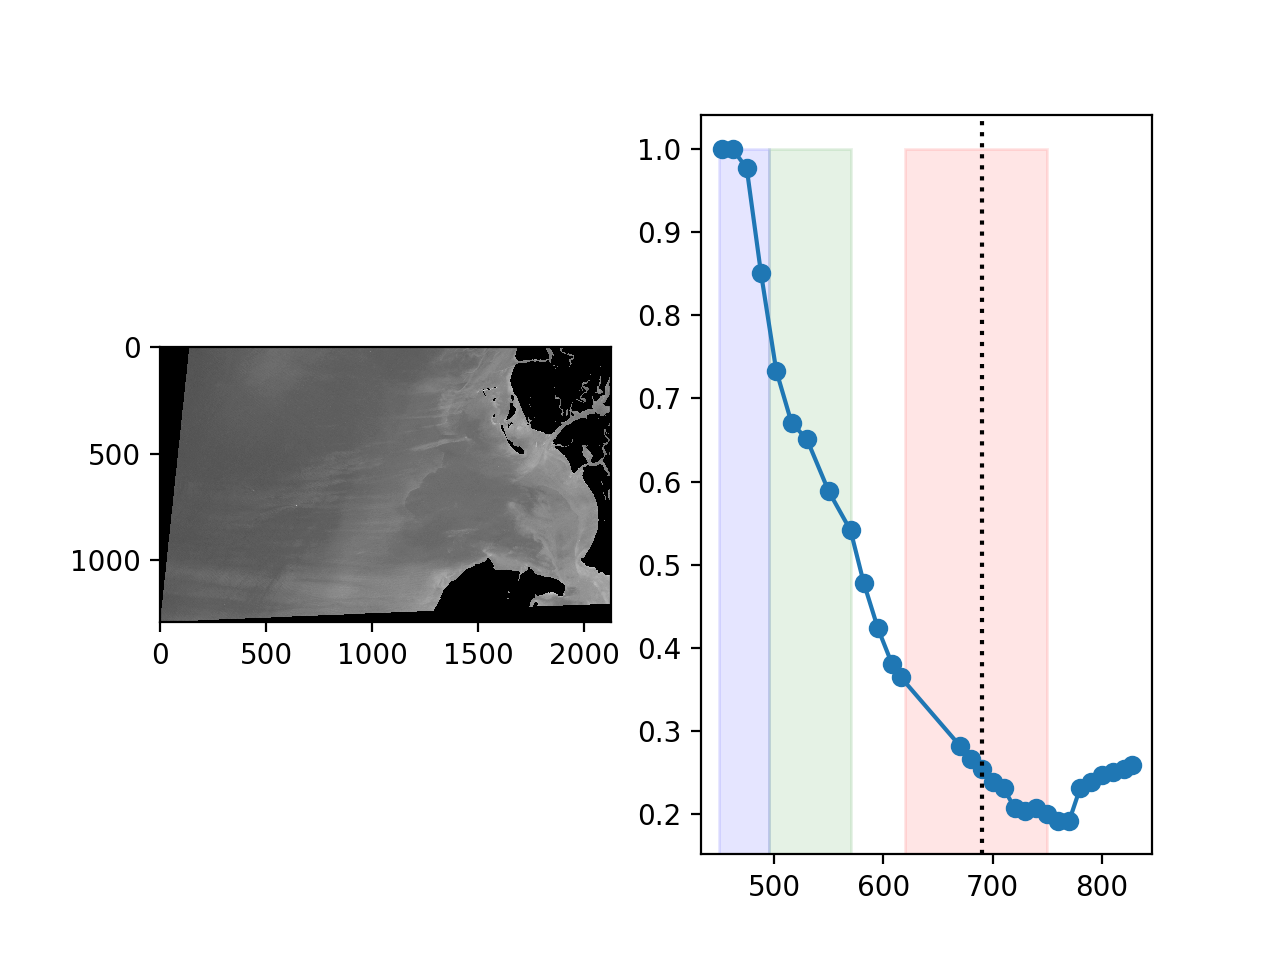

interactive(children=(IntSlider(value=15, description='Channel', max=29), Output()), _dom_classes=('widget-interact',))

In [48]:
ocean=cube
for i in np.arange(cube.shape[2]):
    ocean[:,:,i]=cube[:,:,i]*mask

macro_plot(ocean)

In [64]:
from spectral import *
k=10
loops=10
(m, c) = kmeans(ocean, k, loops)


Initializing clusters along diagonal of N-dimensional bounding box.
Iteration 1...  0.Iteration 1...2245932 pixels reassigned.
Iteration 2...  0.Iteration 2...184065 pixels reassigned.
Iteration 3...  0.Iteration 3...135630 pixels reassigned.
Iteration 4...  0.Iteration 4...108123 pixels reassigned.
Iteration 5...  0.Iteration 5...72732 pixels reassigned.
Iteration 6...  0.Iteration 6...52113 pixels reassigned.
Iteration 7...  0.Iteration 7...40523 pixels reassigned.
Iteration 8...  0.Iteration 8...33474 pixels reassigned.
Iteration 9...  0.Iteration 9...28565 pixels reassigned.
Iteration 10...  0.0Iteration 10...24579 pixels reassigned.
kmeans terminated with 6 clusters after 10 iterations.


<IPython.core.display.Javascript object>


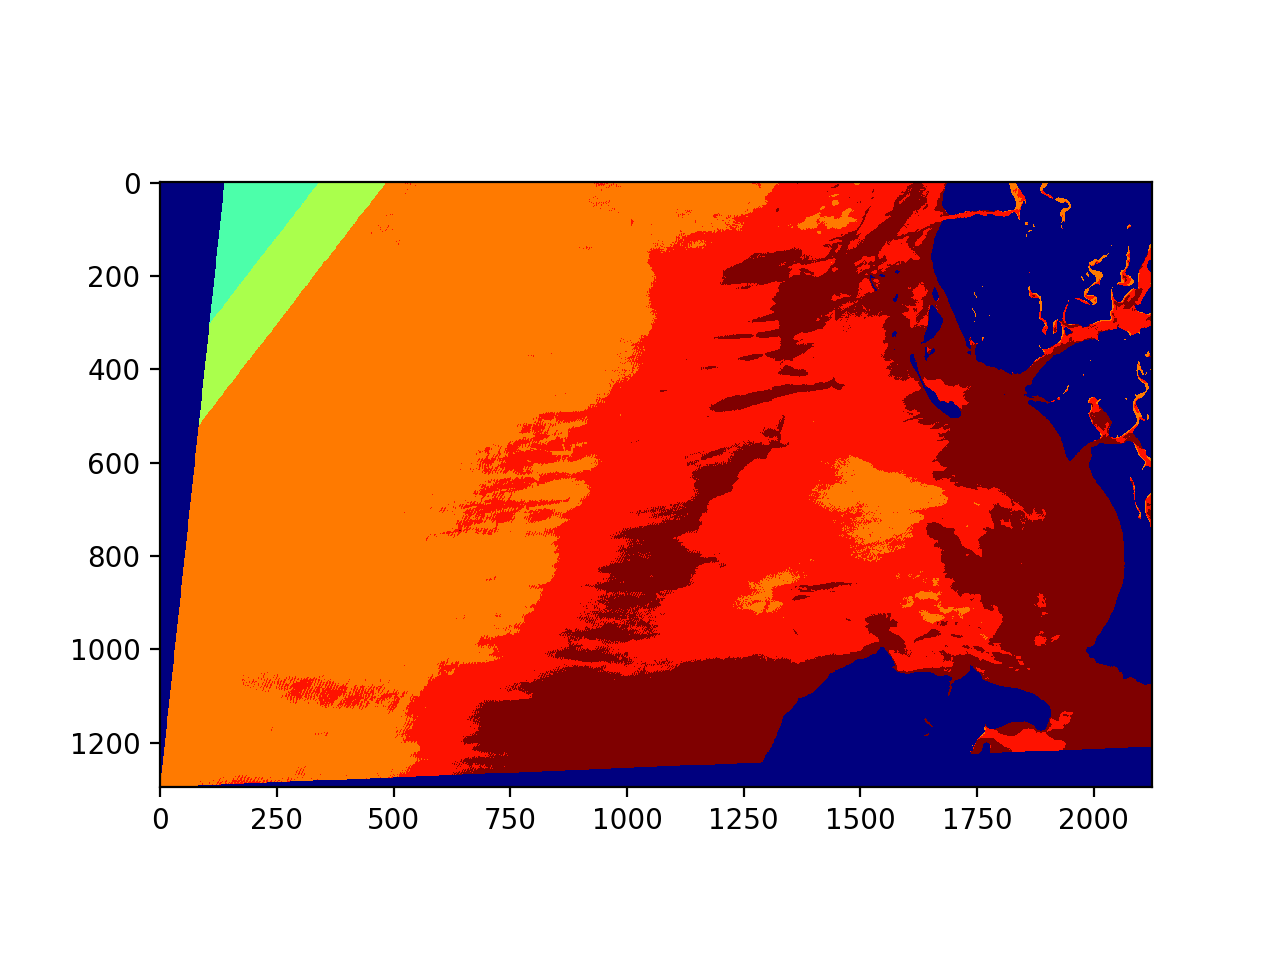

<function matplotlib.pyplot.colorbar>

In [65]:
import matplotlib.cm as cm
km=plt.figure()

base = plt.cm.get_cmap(cm.jet)
cmap=base.from_list('', base(np.linspace(0, 1, k)), k)

plt.imshow(m,cmap=cmap)
plt.colorbar

<IPython.core.display.Javascript object>


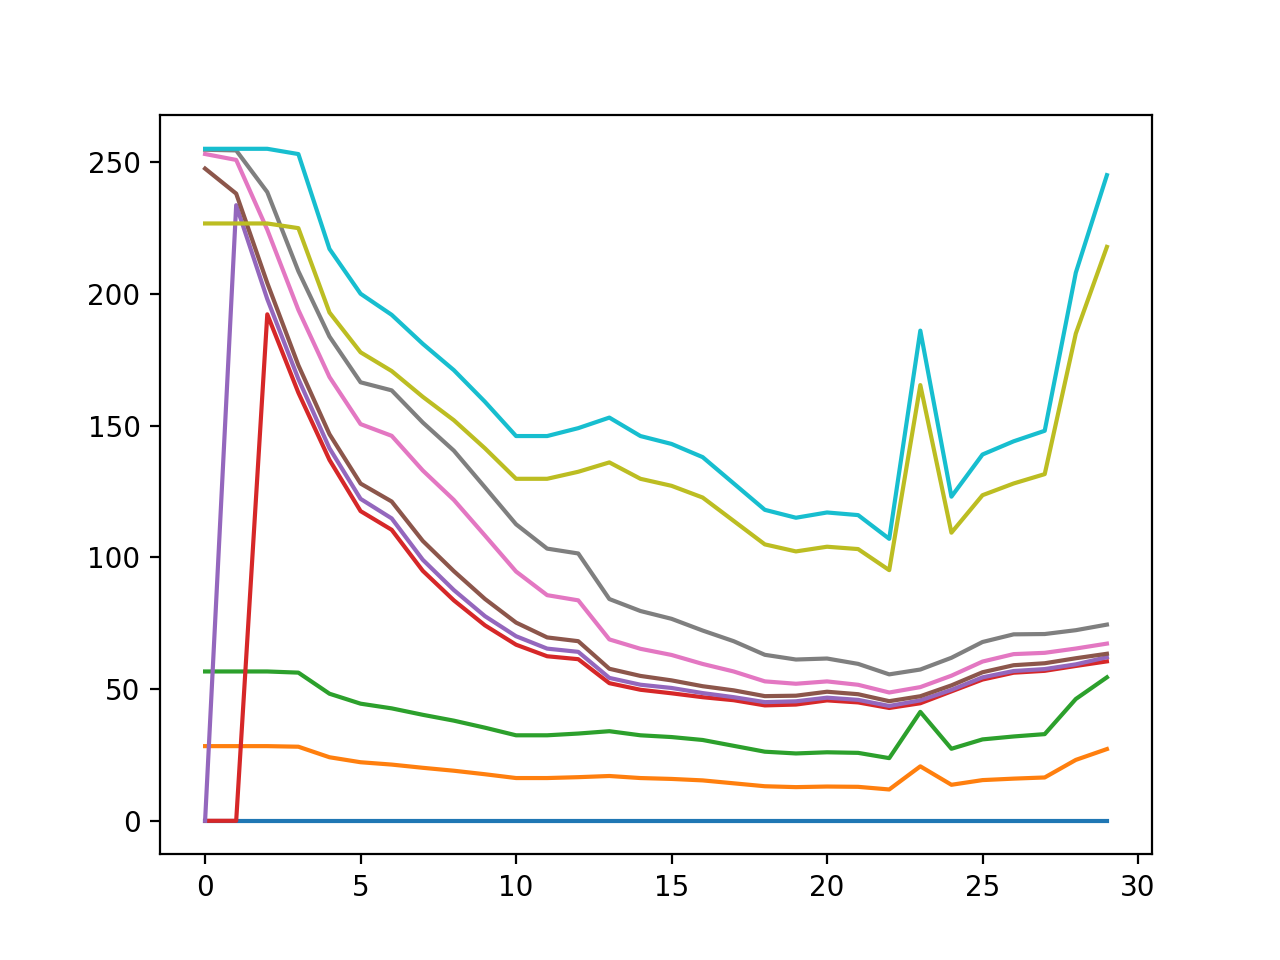

/Users/brunosan/anaconda3/envs/p3/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: The hold function was deprecated in version 2.0.
  This is separate from the ipykernel package so we can avoid doing imports until


In [66]:
import pylab
f=pylab.figure()
f.hold(1)
for i in range(c.shape[0]):
    pylab.plot(c[i])
    
pylab.show()